In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-data-kaggle/Brain_Data_Organised/Stroke/81 (2).jpg
/kaggle/input/brain-data-kaggle/Brain_Data_Organised/Stroke/58 (11).jpg
/kaggle/input/brain-data-kaggle/Brain_Data_Organised/Stroke/94 (3).jpg
/kaggle/input/brain-data-kaggle/Brain_Data_Organised/Stroke/97 (30).jpg
/kaggle/input/brain-data-kaggle/Brain_Data_Organised/Stroke/93 (1).jpg
/kaggle/input/brain-data-kaggle/Brain_Data_Organised/Stroke/68 (12).jpg
/kaggle/input/brain-data-kaggle/Brain_Data_Organised/Stroke/91 (31).jpg
/kaggle/input/brain-data-kaggle/Brain_Data_Organised/Stroke/91 (35).jpg
/kaggle/input/brain-data-kaggle/Brain_Data_Organised/Stroke/80 (5).jpg
/kaggle/input/brain-data-kaggle/Brain_Data_Organised/Stroke/89 (1).jpg
/kaggle/input/brain-data-kaggle/Brain_Data_Organised/Stroke/88 (6).jpg
/kaggle/input/brain-data-kaggle/Brain_Data_Organised/Stroke/93 (34).jpg
/kaggle/input/brain-data-kaggle/Brain_Data_Organised/Stroke/87 (29).jpg
/kaggle/input/brain-data-kaggle/Brain_Data_Organised/Stroke/92 (6).jpg

In [2]:
!pip install imgaug

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 13.4 MB/s eta 0:00:0000:010:01


In [ ]:
# Import necessary libraries
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
import torch
from timm import create_model
from imgaug import augmenters as iaa
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)
tf.random.set_seed(42)

# Step 1: Load and Preprocess the Dataset with Augmentation
def load_dataset(normal_dir, stroke_dir):
    images = []
    labels = []
    class_mapping = {'normal': 0, 'stroke': 1}
    seq = iaa.Sequential([
        iaa.Fliplr(0.5),
        iaa.Affine(rotate=(-10, 10)),
        iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 0.5))),
    ])
    
    for img_name in os.listdir(normal_dir):
        img_path = os.path.join(normal_dir, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = cv2.resize(img, (224, 224))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        images.append(img_rgb)
        labels.append(class_mapping['normal'])
        images_aug = seq.augment_images([img_rgb] * 2)
        images.extend(images_aug)
        labels.extend([class_mapping['normal']] * 2)
    
    for img_name in os.listdir(stroke_dir):
        img_path = os.path.join(stroke_dir, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = cv2.resize(img, (224, 224))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        images.append(img_rgb)
        labels.append(class_mapping['stroke'])
        images_aug = seq.augment_images([img_rgb] * 2)
        images.extend(images_aug)
        labels.extend([class_mapping['stroke']] * 2)
    
    images = np.array(images)
    labels = np.array(labels)
    images = images / 255.0
    return images, labels

normal_dir = "/kaggle/input/brain-data-kaggle/Brain_Data_Organised/Normal"
stroke_dir = "/kaggle/input/brain-data-kaggle/Brain_Data_Organised/Stroke"
images, labels = load_dataset(normal_dir, stroke_dir)

# Balance the dataset
normal_count = np.sum(labels == 0)
stroke_count = np.sum(labels == 1)
print(f"Normal images: {normal_count}, Stroke images: {stroke_count}")

if normal_count > stroke_count:
    normal_indices = np.where(labels == 0)[0]
    stroke_indices = np.where(labels == 1)[0]
    normal_indices = np.random.choice(normal_indices, stroke_count, replace=False)
    selected_indices = np.concatenate([normal_indices, stroke_indices])
    images = images[selected_indices]
    labels = labels[selected_indices]
elif stroke_count > normal_count:
    normal_indices = np.where(labels == 0)[0]
    stroke_indices = np.where(labels == 1)[0]
    stroke_indices = np.random.choice(stroke_indices, normal_count, replace=False)
    selected_indices = np.concatenate([normal_indices, stroke_indices])
    images = images[selected_indices]
    labels = labels[selected_indices]

print(f"After balancing - Normal images: {np.sum(labels == 0)}, Stroke images: {np.sum(labels == 1)}")

# Split the dataset
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.3, random_state=42, stratify=labels)

# Step 2: Feature Extraction Using Vision Transformer (ViT)
def extract_vit_features(images, batch_size=32):
    model = create_model(
        'vit_base_patch16_224',
        pretrained=True,
        num_classes=0,
        drop_rate=0.1  # Hyperparameter: dropout rate in ViT
    )
    model.eval()
    model = model.cuda()
    features_list = []
    for i in range(0, len(images), batch_size):
        batch_images = images[i:i + batch_size]
        images_tensor = torch.tensor(batch_images.transpose(0, 3, 1, 2), dtype=torch.float32).cuda()
        with torch.no_grad():
            batch_features = model(images_tensor)
        features_list.append(batch_features.cpu().numpy())
        torch.cuda.empty_cache()
    features = np.concatenate(features_list, axis=0)
    return features

torch.cuda.empty_cache()
X_train_features = extract_vit_features(X_train, batch_size=32)
X_val_features = extract_vit_features(X_val, batch_size=32)
print(f"ViT feature shape: {X_train_features.shape}")

# Step 3: Standardize Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_features)
X_val_scaled = scaler.transform(X_val_features)

# Step 4: Feature Selection Using LASSO with Grid Search
lasso_params = {'alpha': [0.001, 0.01, 0.1, 1.0]}  # Hyperparameter: LASSO regularization strength
lasso = Lasso(random_state=42)
grid_search = GridSearchCV(lasso, lasso_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)
best_lasso = grid_search.best_estimator_
print(f"Best LASSO alpha: {grid_search.best_params_['alpha']}")

selected_features = np.abs(best_lasso.coef_) > 1e-5
X_train_selected = X_train_scaled[:, selected_features]
X_val_selected = X_val_scaled[:, selected_features]
print(f"Selected feature shape: {X_train_selected.shape}")

# Step 5: Build and Train DenseNet with Learning Rate Tuning
def build_densenet(input_shape, learning_rate=0.001):
    base_model = tf.keras.applications.DenseNet121(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape,
        pooling=None
    )
    base_model.trainable = False
    
    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)  # Hyperparameter: dropout rate
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)  # Hyperparameter: dropout rate
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),  # Hyperparameter: learning rate
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Try multiple learning rates
learning_rates = [0.0001, 0.001, 0.01]
best_val_accuracy = 0
best_model = None
best_lr = None

for lr in learning_rates:
    print(f"Training with learning rate: {lr}")
    model = build_densenet(input_shape=(224, 224, 3), learning_rate=lr)
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=32,  # Hyperparameter: batch size
        callbacks=[early_stopping, reduce_lr],
        class_weight={0: 1.0, 1: 1.2},  # Hyperparameter: class weight
        verbose=1
    )
    
    val_accuracy = max(history.history['val_accuracy'])
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model = model
        best_lr = lr

print(f"Best learning rate: {best_lr}")

# Step 6: Evaluate the Best Model
y_pred_prob = best_model.predict(X_val)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

2025-05-19 12:58:04.033237: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747659484.257628      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747659484.326116      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Normal images: 4653, Stroke images: 2850
After balancing - Normal images: 2850, Stroke images: 2850


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

ViT feature shape: (3990, 768)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.214e+01, tolerance: 7.980e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.904e+01, tolerance: 7.980e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.559e+01, tolerance: 7.980e

Best LASSO alpha: 0.001
Selected feature shape: (3990, 529)
Training with learning rate: 0.0001
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50


I0000 00:00:1747659625.157642     121 service.cc:148] XLA service 0x7a627400cc00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747659625.158475     121 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1747659625.158495     121 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1747659627.993641     121 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1:08:14 33s/step - accuracy: 0.4062 - loss: 1.0510

I0000 00:00:1747659639.536060     121 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


125/125 ━━━━━━━━━━━━━━━━━━━━ 83s 402ms/step - accuracy: 0.5082 - loss: 0.8314 - val_accuracy: 0.6082 - val_loss: 0.6589 - learning_rate: 1.0000e-04
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 110ms/step - accuracy: 0.5692 - loss: 0.7494 - val_accuracy: 0.6608 - val_loss: 0.6303 - learning_rate: 1.0000e-04
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 114ms/step - accuracy: 0.5890 - loss: 0.7259 - val_accuracy: 0.6696 - val_loss: 0.6108 - learning_rate: 1.0000e-04
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 118ms/step - accuracy: 0.6272 - loss: 0.6980 - val_accuracy: 0.7018 - val_loss: 0.5893 - learning_rate: 1.0000e-04
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 120ms/step - accuracy: 0.6355 - loss: 0.6895 - val_accuracy: 0.7257 - val_loss: 0.5654 - learning_rate: 1.0000e-04
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 118ms/step - accuracy: 0.6794 - loss: 0.6600 - val_accuracy: 0.7357 - val_loss: 0.5480 - learning_rate: 1.0000e-04
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 115ms/step - 

In [4]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predict probabilities on validation set
y_pred_prob = best_model.predict(X_val)

# Convert probabilities to class predictions (binary classification)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Evaluate metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

# Print metrics
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-Score : {f1:.4f}")


54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step
Accuracy : 0.9257
Precision: 0.9136
Recall   : 0.9404
F1-Score : 0.9268


In [23]:
# Step 7: Save the Best Model
model_save_path = "best_brain_stroke_model.h5"
best_model.save(model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to best_brain_stroke_model.h5


In [48]:
import matplotlib.pyplot as plt
import os

def plot_model_metrics(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    # Save to Kaggle's working directory
    #plt.savefig('/kaggle/working/model_metrics.png')
    #plt.close()

# Verify file exists
#def check_output():
    #print("Files in /kaggle/working:", os.listdir('/kaggle/working'))

# Example usage
# plot_model_metrics(best_history)
# check_output()

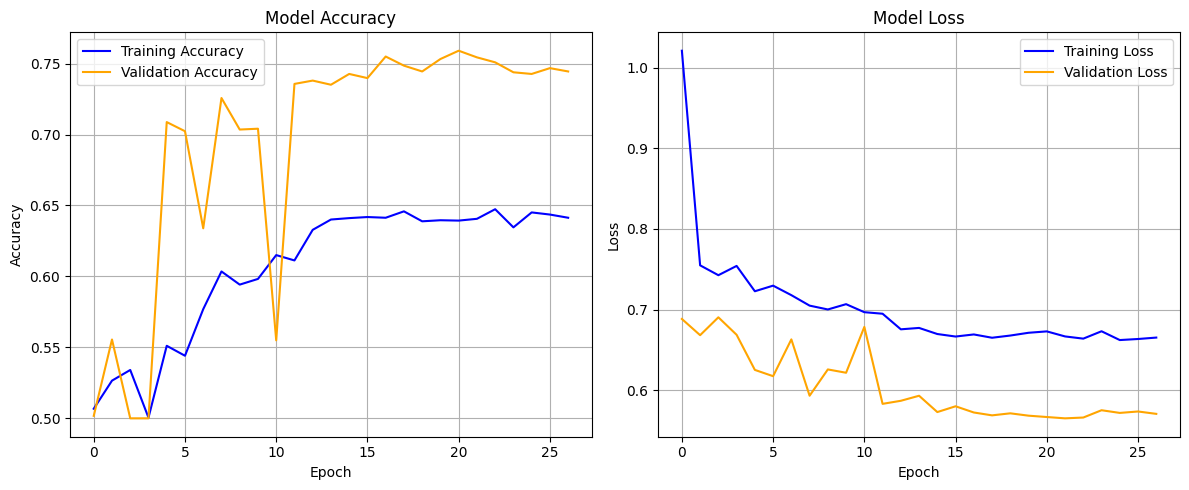

In [49]:
plt.show(plot_model_metrics(history))

In [78]:
import matplotlib.pyplot as plt
from IPython.display import Image, display

def plot_precision_recall_f1(history):
    # Create a figure with three subplots
    plt.figure(figsize=(18, 5))

    # Subplot 1: Precision
    plt.subplot(1, 3, 1)
    plt.plot(history.history['precision'], label='Training Precision', color='blue')
    plt.plot(history.history['val_precision'], label='Validation Precision', color='orange')
    plt.title('Model Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid(True)

    # Subplot 2: Recall
    plt.subplot(1, 3, 2)
    plt.plot(history.history['recall'], label='Training Recall', color='blue')
    plt.plot(history.history['val_recall'], label='Validation Recall', color='orange')
    plt.title('Model Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()
    plt.grid(True)

    # Subplot 3: F1-Score
    plt.subplot(1, 3, 3)
    plt.plot(history.history['f1'], label='Training F1', color='blue')
    plt.plot(history.history['val_f1'], label='Validation F1', color='orange')
    plt.title('Model F1-Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1-Score')
    plt.legend()
    plt.grid(True)

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Save the plot to Kaggle's output directory
    output_path = '/kaggle/working/precision_recall_f1.png'
    plt.savefig(output_path)
    plt.close()

    # Display the saved image in the notebook
    display(Image(filename=output_path))

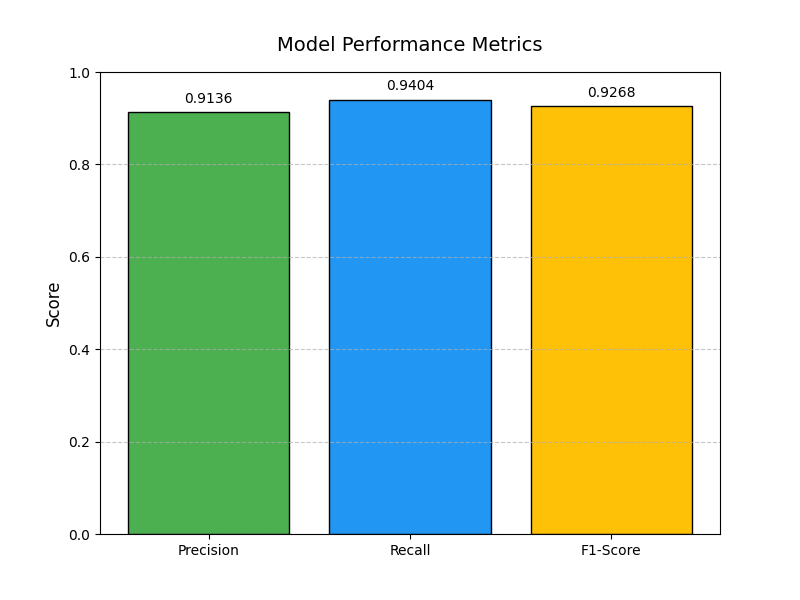

In [79]:
from IPython.display import Image, display

# Path to the image
image_path = '/kaggle/working/precision_recall_f1_plot.png'

# Display the image
display(Image(filename=image_path))

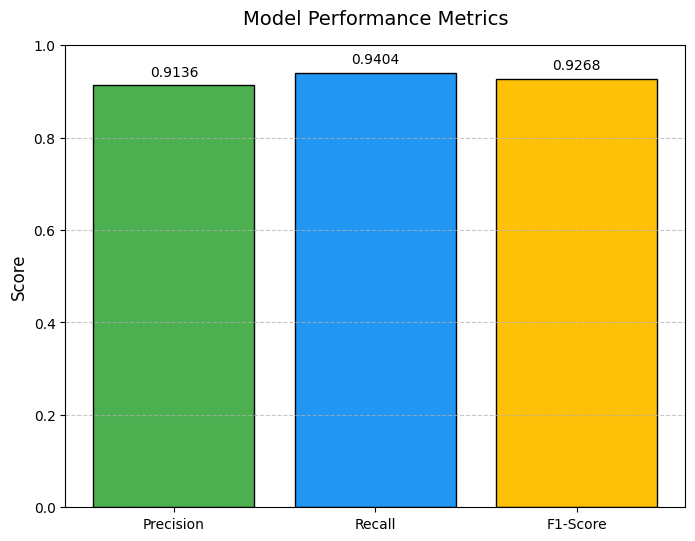

In [64]:
import matplotlib.pyplot as plt
# Metrics from the model evaluation
accuracy = 0.9257 # Placeholder, not used in the plot but included for context
precision = 0.9136  # Replace with actual precision value
recall = 0.9404    # Replace with actual recall value
f1 =0.9268       # Replace with actual F1-score value

# Data for plotting
metrics = ['Precision', 'Recall', 'F1-Score']
values = [precision, recall, f1]

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['#4CAF50', '#2196F3', '#FFC107'], edgecolor='black')
plt.ylim(0, 1)  # Assuming metrics are between 0 and 1
plt.title('Model Performance Metrics', fontsize=14, pad=15)
plt.ylabel('Score', fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of each bar
for i, value in enumerate(values):
    plt.text(i, value + 0.02, f'{value:.4f}', ha='center', fontsize=10)

# Save the plot
#plt.savefig('precision_recall_f1_plot.png')
#plt.close()
plt.show()

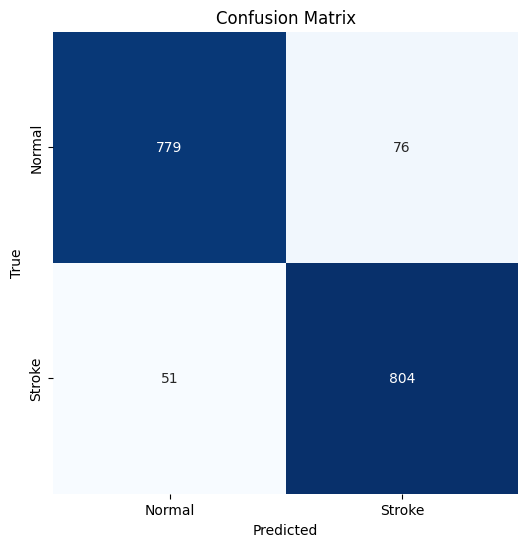

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes=['Normal', 'Stroke']):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Create figure
    plt.figure(figsize=(6, 6))
    
    # Plot heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=classes, yticklabels=classes)
    
    # Labels and title
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # Save plot
    #plt.savefig('confusion_matrix.png')
    #plt.close()
    plt.show()

# Example usage (replace with actual y_val and y_pred)
plot_confusion_matrix(y_val, y_pred)